In [1]:
# Step-2:
#### 1. Image Contrast
#### 2. Data Split (Train(80), Validation(20))
#### 3. Transfer learning

In [1]:
import numpy as np
import tensorflow as tf
import keras
from imageContrast import img_cont
from skimage import exposure
from pylab import *
from keras.models import Sequential
from keras import regularizers
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import AUC
from imageCropping import crop_img

In [2]:
trainingDataPath = 'C:/Users/v4run/OneDrive/Desktop/Datasets/C-NMC_Leukemia/TrainingDataset'

In [11]:
def imgContrastPreprocess(images, labels):
    equalized_images = tf.map_fn(lambda img: tf.py_function(img_cont, [img], Tout=tf.float32), images, fn_output_signature=tf.float32)
    return equalized_images, labels

In [4]:
train_data = tf.keras.utils.image_dataset_from_directory(
    trainingDataPath,
    seed=21,
    image_size=(256, 256),
    batch_size=32,
    validation_split=0.2,
    subset='training'
)

Found 9625 files belonging to 2 classes.
Using 7700 files for training.


In [5]:
val_data = tf.keras.utils.image_dataset_from_directory(
    trainingDataPath,
    seed=21,
    image_size=(256, 256),
    batch_size=32,
    validation_split=0.2,
    subset='validation'
)

Found 9625 files belonging to 2 classes.
Using 1925 files for validation.


In [11]:
trainDataset = train_data.map(imgContrastPreprocess).repeat()

In [12]:
validDataset = val_data.map(imgContrastPreprocess)

In [13]:
# Model Structure

In [14]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.35))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[AUC(name='auc')])
earlyStopping = EarlyStopping(monitor='val_auc', patience=5, verbose=1, mode='max')
history = model.fit(
    trainDataset,
    steps_per_epoch=floor(7700//32),
    epochs=100,
    validation_data=validDataset,
    validation_steps=floor(1925//32),
    callbacks=[earlyStopping]
)

loss, accuracy = model.evaluate(validDataset,steps=floor(1925//32))

Epoch 1/100
240/240 [==============================] - 644s 3s/step - loss: 0.5700 - auc: 0.7722 - val_loss: 0.4222 - val_auc: 0.8857
Epoch 2/100
240/240 [==============================] - 622s 3s/step - loss: 0.3964 - auc: 0.8939 - val_loss: 0.4961 - val_auc: 0.9239
Epoch 3/100
240/240 [==============================] - 620s 3s/step - loss: 0.3334 - auc: 0.9264 - val_loss: 0.3368 - val_auc: 0.9278
Epoch 4/100
240/240 [==============================] - 614s 3s/step - loss: 0.2871 - auc: 0.9456 - val_loss: 0.4630 - val_auc: 0.9372
Epoch 5/100
240/240 [==============================] - 612s 3s/step - loss: 0.2655 - auc: 0.9532 - val_loss: 0.2922 - val_auc: 0.9487
Epoch 6/100
240/240 [==============================] - 618s 3s/step - loss: 0.2139 - auc: 0.9698 - val_loss: 0.2509 - val_auc: 0.9593
Epoch 7/100
240/240 [==============================] - 578s 2s/step - loss: 0.1835 - auc: 0.9779 - val_loss: 0.4209 - val_auc: 0.9550
Epoch 8/100
240/240 [==============================] - 571s 2s

In [15]:
model.save('C:/Users/v4run/OneDrive/Desktop/Datasets/C-NMC_Leukemia/models/fourLayerModel.h5')

In [19]:
acc = history.history['auc']
loss = history.history['loss']
val_acc = history.history['val_auc']
val_loss = history.history['val_loss']

In [17]:
epoch = range(1, len(acc)+1)

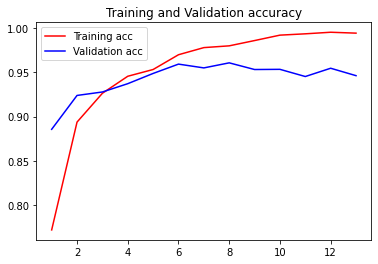

In [18]:
plt.plot(epoch, acc, 'r', label = 'Training acc')
plt.plot(epoch, val_acc, 'b', label = 'Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()
plt.show()

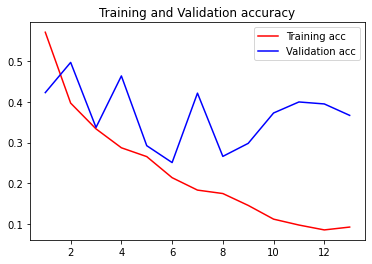

In [20]:
plt.plot(epoch, loss, 'r', label = 'Training acc')
plt.plot(epoch, val_loss, 'b', label = 'Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()
plt.show()

In [21]:
# Test Data

In [2]:
testingDataPath = 'C:/Users/v4run/OneDrive/Desktop/Datasets/C-NMC_Leukemia/training_data/fold_2'

In [3]:
test_data = tf.keras.utils.image_dataset_from_directory(
    testingDataPath,
    seed=21,
    image_size=(256, 256),
    batch_size=32
)

Found 3553 files belonging to 2 classes.


In [4]:
#crop Data

In [5]:
def imgCropPreprocess(images,labels):
    cropped_images = tf.map_fn(lambda img: tf.py_function(crop_img, [img], Tout=tf.float32), images)
    return cropped_images,labels

In [6]:
testCropped_data = test_data.map(imgCropPreprocess)

In [7]:
a = testCropped_data.as_numpy_iterator()

In [8]:
img, label = a.next()

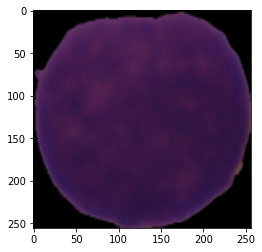

In [9]:
imshow(img[0])

In [12]:
testCont_data = testCropped_data.map(imgContrastPreprocess)

In [18]:
saved_model = tf.keras.models.load_model('C:/Users/v4run/OneDrive/Desktop/Datasets/C-NMC_Leukemia/models/fourLayerModel.h5')

In [19]:
# prediction

In [20]:
y_predict = saved_model.predict(testCont_data)

112/112 [==============================] - 174s 2s/step


In [21]:
y_predict_binary = (y_predict>0.5).astype(int)

In [24]:
y_pred = np.round(y_predict).flatten()

In [25]:
y_predict_binary

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [26]:
y_pred

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [23]:
y_true = np.concatenate([y for x, y in testCont_data], axis=0)

In [29]:
precision = precision_score(y_true,y_pred)
recall = recall_score(y_true,y_pred)
f1Score = f1_score(y_true, y_pred)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'f1_score: {f1Score:.4f}')

Precision: 0.6901
Recall: 0.1559
f1_score: 0.2543


In [28]:
confusionMatrix = confusion_matrix(y_true, y_predict_binary)
print(confusionMatrix)

[[ 924  172]
 [2074  383]]
